# Furniture classification

## t-SNE

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import utilities.training as training
import utilities.visuals  as visuals
import utilities.data     as data

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import pandas as pd
from tqdm import tqdm_notebook, tqdm

### Utilities

In [4]:
def display_image(img_path, title=None):
    import cv2
    import matplotlib.pyplot as plt
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    if title:
        plt.title(title)
    plt.show()  

## Reading the dataset

In [5]:
def path_to_tensor(img_path):
    import numpy as np
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224), grayscale=True)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    import numpy as np
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
class ImageDataset(object):
    @staticmethod
    def load(dataset_path):
        csv = pd.read_csv('{}/data.csv'.format(dataset_path))
        images = [
            '{}/images/{}.jpg'.format(dataset_path, image_id)
            for image_id in csv['image_id'].as_matrix()
        ]
        labels = csv['label_id'].as_matrix()
        return ImageDataset(images, labels)
    
    def __init__(self, images, labels):
        from collections import defaultdict
        self.images = images
        self.labels = labels
        self.tensors = None
        self.label_to_image_idx = defaultdict(list)
        for index in range(len(self.images)):
            self.label_to_image_idx[self.labels[index]]\
                .append(index)
        self.path_to_label = {
            self.images[idx]: self.labels[idx]
            for idx in range(len(self.images))
        }
        
    def sample(self, n):
        import random
        idxs = random.sample(list(range(len(self.images))), n)
        return ImageDataset(
            np.array(self.images)[idxs],
            np.array(self.labels)[idxs])

    def images_of(self, label):
        return [self.images[idx]
                for idx in self.label_to_image_idx[label]]
        
    @property
    def classes(self):
        return len(set(self.labels))
    
    def as_paths(self):
        return np.array(self.images)
    
    def as_targets(self):
        import numpy as np
        from keras.utils import np_utils
        return np_utils.to_categorical(np.array(self.labels), self.classes)
    
    def as_tensors(self):
        if self.tensors:
            return self.tensors
        self.tensors = paths_to_tensor(self.images).astype('float64') #  / 255
        return self.tensors
    
    def __len__(self):
        return len(self.images)
    
    def __repr__(self):
        return "ImageDataset(len={})".format(len(self))

In [7]:
!ls datasets

dataset_1000  dataset_2500  dataset_5000


In [8]:
dataset = ImageDataset.load('datasets/dataset_2500')

## t-SNE

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from tsne import bh_sne

In [10]:
x_data = dataset.as_tensors()

100%|██████████| 2500/2500 [00:20<00:00, 122.93it/s]


In [11]:
x_data.shape

(2500, 224, 224, 1)

In [12]:
x_data = x_data.reshape((x_data.shape[0], -1))
y_data = dataset.labels

In [13]:
x_data.shape

(2500, 50176)

In [14]:
vis_data = bh_sne(x_data, perplexity=20.)

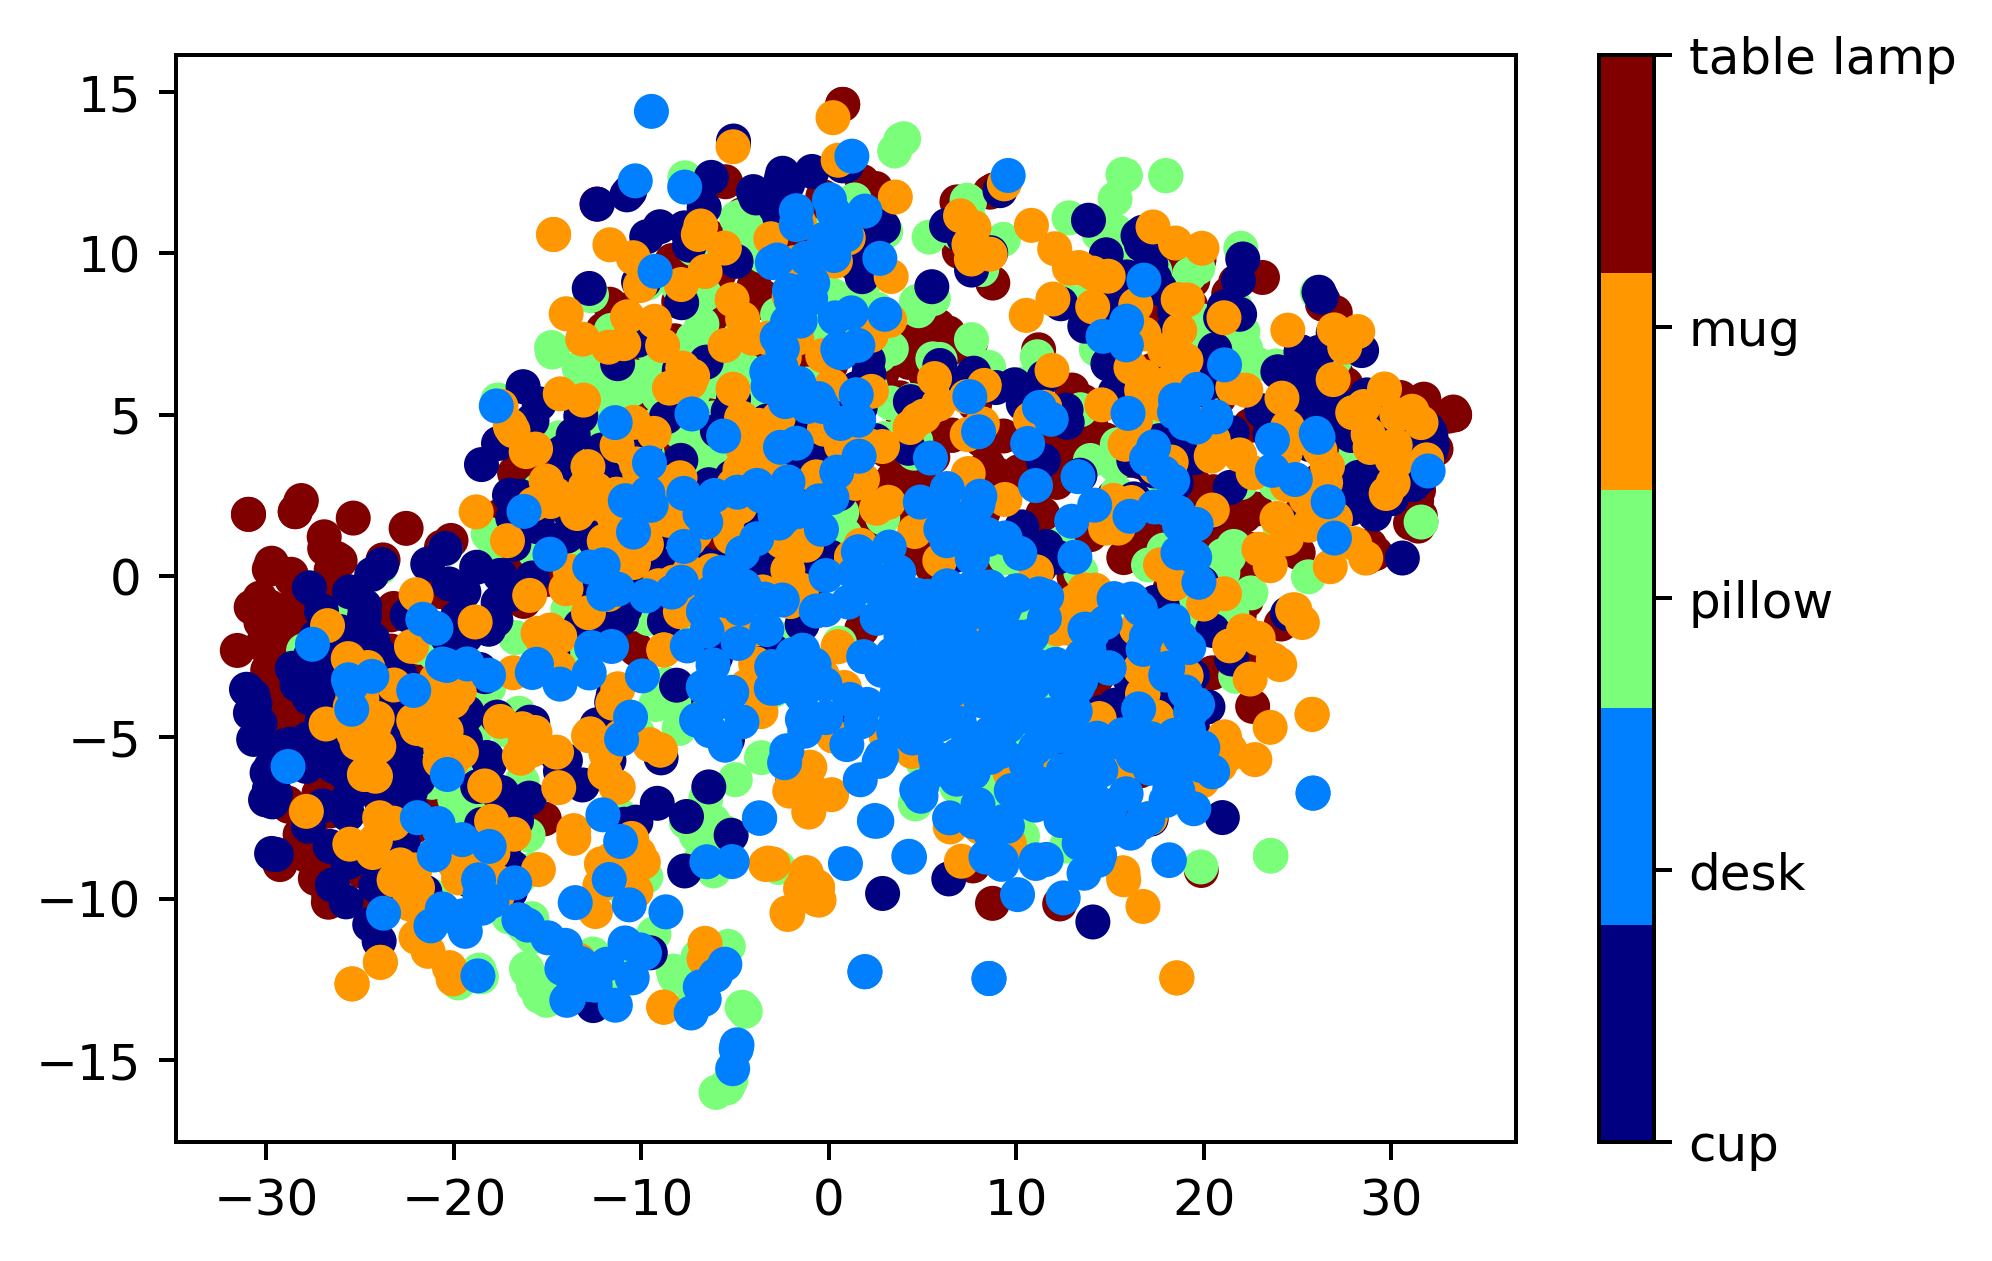

In [15]:
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.figure(dpi=180)
plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 5))
plt.clim(0, 4)
cbar = plt.colorbar(ticks=range(5))
cbar.ax.set_yticklabels(['glass', 'desk', 'pillow', 'mug', 'table lamp'])
plt.show()